(unsupervised:density-clustering:optics)=
# OPTICS

OPTICS (ordering points to identify the clustering structure) is an extension of DBSCAN, which automatically chooses $\varepsilon$ and allows for cluster-dependent $\varepsilon$. Instead of $\varepsilon$ OPTICS requires a parameter $\varepsilon_{\mathrm{max}}$ describing the maximum value to consider when choosing $\varepsilon$. This parameter has to be chosen large enough to not miss a cluster but there is no upper bound. The larger $\varepsilon_{\mathrm{max}}$ the more computation time is required while clustering results remain the same. Thus, choosing a good $\varepsilon_{\mathrm{max}}$ is only important for large scale data sets.

OPTICS differs from DBSCAN as follows:
* Neighborhood radius $\varepsilon$ depends on the point $x$ under consideration. It is chosen as small as possible but large enough to have $N$ points (including $x$) in the $\varepsilon(x)$-neighborhood. In this sense every point is a core point, at least if $\varepsilon_{\mathrm{max}}$ is large enough (which we assume below).
* The direct output of the OPTICS algorithm is not a clustering. Instead, to each processed point a numerical value, the *reachability distance*, is assigned. These values imply a linear ordering of all processed points. From this ordering a clustering can be deduced by several different methods (see below).

## Basic Algorithm

During runtime of OPTICS algorithm each point is in one of three states: untouched or discovered or processed. At the beginning all points are untouched, at the end all points will be processed (if $\varepsilon_{\mathrm{max}}$ is large enough).

OPTICS, like DBSCAN, starts at an arbitrary point $x$. For each point $\tilde{x}$ in the $\varepsilon_{\mathrm{max}}$-neighborhood of $x$ then the reachability distance is computed as
\begin{equation*}
\max\{\varepsilon(x), |x-\tilde{x}|\},
\end{equation*}
all points but $x$ are appended to the list of discovered (but unprocessed) points and $x$ is marked as processed.
Now the following steps are repeated until no discovered but unprocessed points remain:
* The point with lowest reachability distance is chosen from the list of discovered points and marked as processed.
* For all unprocessed points in its $\varepsilon_{\mathrm{max}}$-neighborhood reachability distances with respect to the point are computed.
* If such an unprocessed neighboring point already has been discovered before, the smaller one of old and new reachability distance is chosen. If a neighboring point has been discovered for the first time, it is added to the list of discovered points.

## Implementation from Scratch

Note that efficient implementation of OPTICS algorithm requires knowledge of advanced data structures. For understanding the basic principles here we only provide an inefficient implementation avoiding any use of advanced data structures. Further we set $\varepsilon_{\mathrm{max}}=\infty$, that is, instead of (large) neighborhoods we always discover the whole data set. Consequently, there will be no untouched points after processing the starting point.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

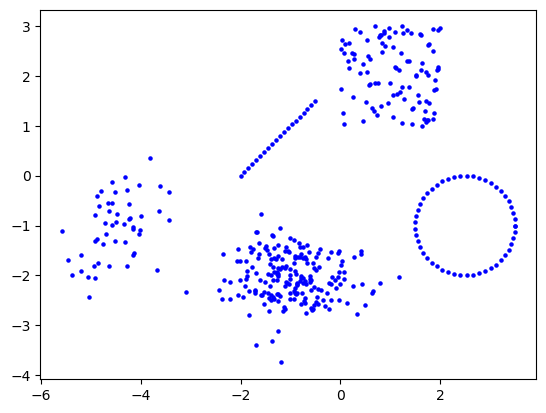

In [2]:
# 5 clusters in 2 dimensions

n1, n2, n3, n4, n5 = 100, 200, 20, 50, 50
n = n1 + n2 + n3 + n4 + n5

X1 = rng.uniform((0, 1), (2, 3), (n1, 2))
X2 = rng.multivariate_normal((-1, -2), ((0.5, 0), (0, 0.2)), n2)
X3 = np.linspace(-1, 0.5, n3).reshape(-1, 1) * np.ones((1, 2)) + np.array([[-1, 1]])
X4 = rng.multivariate_normal((-4.5, -1), ((0.2, 0.1), (0.1, 0.4)), n4)
phi = np.linspace(0, 2 * np.pi, n5).reshape(-1, 1)
X5 = np.array([[2.5, -1]]) + np.concatenate((np.cos(phi), np.sin(phi)), axis=1)

X = np.concatenate((X1, X2, X3, X4, X5))

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=5, c='b')
ax.axis('equal')
plt.show()

In [3]:
N = 10
start_idx = 0

n = X.shape[0]

dists = np.empty(n)    # reachability distances
epss = np.empty(n)    # epsilons
processed = np.full(n, False)    # point already processed?
order = np.empty(n, dtype=int)    # indices in the order of processing (for identifying clusters)
previous = np.empty(n, dtype=int)    # index of core point with shortest distance (for visualization only)

# calculate pairwise distances
D = np.empty((n, n))
for l in range(0, n):
    D[l, l] = 0
    for ll in range(0, l):
        D[l, ll] = np.sqrt(np.sum((X[l, :] - X[ll, :]) ** 2))
        D[ll, l] = D[l, ll]

# calculate epsilon for each point
for l in range(0, n):
    epss[l] = np.sort(D[l, :])[N]
    
# calculate reachability distances with respect to starting point
x = X[start_idx, :]
for l in range(0, n):
    dists[l] = np.maximum(epss[start_idx], D[start_idx, l])
    previous[l] = start_idx
processed[start_idx] = True
order[0] = start_idx
previous[start_idx] = -1    # no predecessor
    
# process all points
for i in range(1, n):
    
    # get next core point (the one closest to set of processed points)
    dists_sort = np.argsort(dists)
    idx_sorted = np.flatnonzero(processed[dists_sort] == False)[0]
    idx = dists_sort[idx_sorted]
    processed[idx] = True
    order[i] = idx
    
    # update reachability distances
    for l in np.flatnonzero(processed == False):
        new_dist = np.maximum(epss[idx], D[idx, l])
        if new_dist < dists[l]:
            dists[l] = new_dist
            previous[l] = idx

## Identifying Clusters

When OPTICS algorithm has finished we have the processing order and shortest reachability distances (SRD) of all points. The SRD of a point tells us how far away the point was from the already processed points before it got processed itself. As long as SRDs remain small while processing point by point, new points are close to previous ones. If SRD suddenly increases, then there are no more close points left. Thus, all points of a cluster have been processed and the processing of a new cluster starts.

If we plot SRD versus position in the processed chain of points, we may identify valleys as clusters. To extract a clustering from OPTICS results we have to identify valleys in the plot. Points with high SRD (mountains between valleys) can be interpreted as outliers.

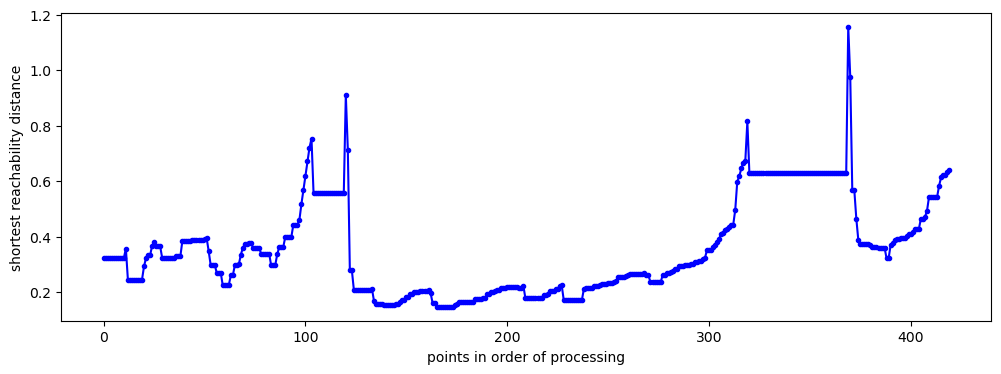

In [4]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dists[order] , '-ob', markersize=3)
ax.set_xlabel('points in order of processing')
ax.set_ylabel('shortest reachability distance')
plt.show()

There exist several algorithms for finding valleys in the plot. One could look for steep decents or ascents or one could look for almost constant regions. Depending on the sensitivity of this valley search more or less clusters will be found. With different levels of sensitivity we would obtain a sequence of nested clusterings. In this sense, OPTICS algorithm is sometimes classified as hierarchical clustering method.

Here we do not go into the details of automatically identifying clusters.

In [5]:
labels = np.full(n, -1, dtype=int)

labels[order[0:97]] = 0
labels[order[103:120]] = 1
labels[order[120:310]] = 2
labels[order[319:369]] = 3
labels[order[369:]] = 4

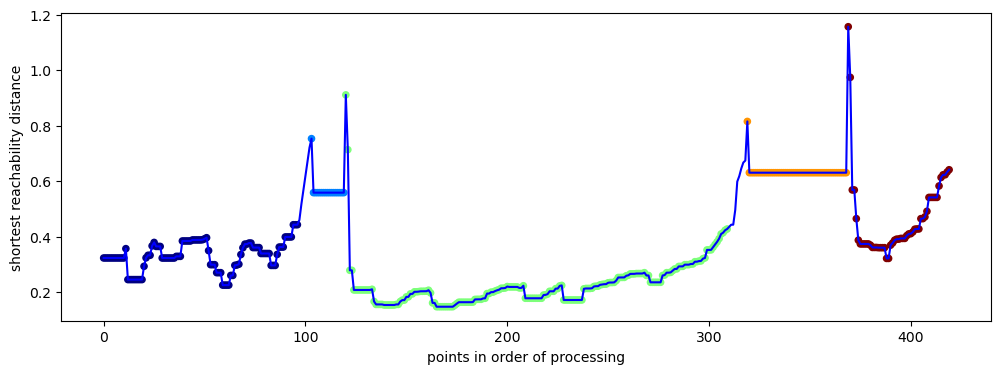

In [6]:
mask = labels != -1

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dists[order] , '-b', markersize=3)
ax.scatter(np.arange(0, n)[mask[order]], dists[order][mask[order]],
           s=20, c=labels[order][mask[order]], cmap='jet')
ax.set_xlabel('points in order of processing')
ax.set_ylabel('shortest reachability distance')
plt.show()

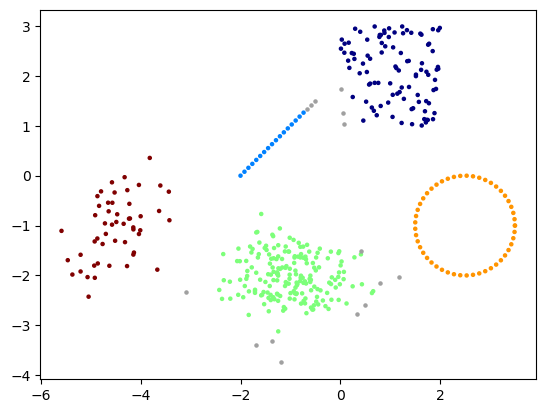

In [7]:
fig, ax = plt.subplots()
mask = labels != -1
ax.scatter(X[mask, 0], X[mask, 1], s=5, c=labels[mask], cmap='jet')
ax.scatter(X[mask == False, 0], X[mask == False, 1], s=5, c='#A0A0A0')
ax.axis('equal')
plt.show()

## Visualizing Processing Order and Reachability

For getting some more insight into OPTICS algorithm we may visualize the processing order. On the one hand we could color each point by its position in the chain of processed points. On the other hand we could connect each point with its closest core point, that is, with the point used in the computation of the shortest reachability distance.

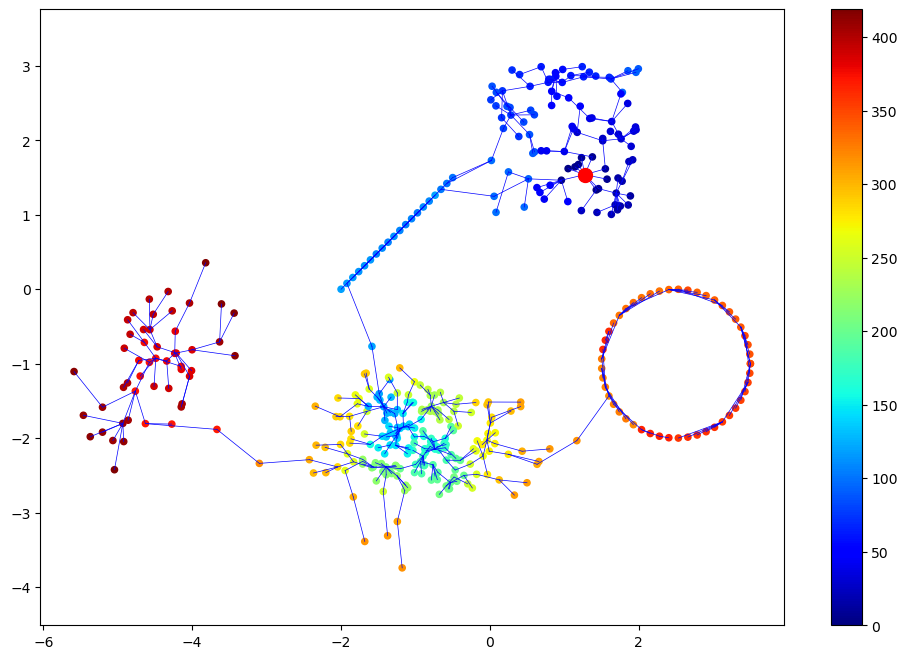

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))

# connections
for l in range(0, n):
    if previous[l] != -1:
        ax.plot([X[previous[l], 0], X[l, 0]], [X[previous[l], 1], X[l, 1]], '-b', markersize=3, linewidth=0.5)

# colored points
c = np.empty(n)
c[order] = np.arange(0, n)
plot = ax.scatter(X[:, 0], X[:, 1], s=20, c=c, cmap='jet')
fig.colorbar(plot, ax=ax)

# starting point
ax.plot(X[start_idx, 0], X[start_idx, 1],'-or', markersize=10)

ax.axis('equal')
plt.show()

All connections together constitute a graph which is tree shaped and spans the data set, a so called *spanning tree*. This graph may be used for further investigation of the data set, for instance, to visualize high dimensional data sets in two dimensions without loosing too much structure.

Unfortunately there seems to be no Python package supporting tree visualization with prescribed edge lengths and having a simple API. Thus, we write our own tree visualization function.

In [9]:
def plot_tree(prevs, dists, core_dists, ax, root_x=0, root_y=0):
    ''' Plot tree with prescribed edge lengths.
    Only plots the edges, not the nodes. Node positions are
    returnd as NumPy array of shape (n_samples, 2)
    
    prevs ... 1d array with predecessor (parent) for each node (root has -1)
    dists ... distance to predecessor
    core_dists ... distance considered as close to the node (close leaves will
                   be visualized closer than prescribed by dists)
    '''

    n = len(prevs)
    
    # for each node create list of children
    children = [[] for i in range(0, n)]
    for i in range(0, n):
        if prevs[i] != -1:
            children[prevs[i]].append(i)
        else:
            root = i

    # randomly permutate children of each node (for better visual impression)
    for i in range(0, n):
        if len(children[i]) > 0:
            children[i] = list(np.random.default_rng(0).permuted(children[i]))

    # array for node positions
    pos = np.empty((n, 2))
    
    # place root on stack of nodes to process
    pos[root, 0] = 0
    pos[root, 1] = 0
    stack = [root]

    # process nodes until stack is empty
    while len(stack) > 0:
        node = stack.pop()
        for i, child in enumerate(children[node]):
            
            # radius (distance to parent node)
            r = dists[child]
            if r <= core_dists[node]:
                r = 0.3 * core_dists[node]

            # angle
            if node == root:
                # evenly distribute children around root
                angle = 2 * np.pi / len(children[node]) * (i + 0.5)
            else:
                # evenly distribute children in a 180° region around node,
                # rotate 180° region to look away from parent of current node
                parent_angle = np.arctan2(pos[node, 1] - pos[prevs[node], 1], pos[node, 0] - pos[prevs[node], 0])
                angle = np.pi / len(children[node]) * (i + 0.5) - 0.5 * np.pi + parent_angle
            
            # child position
            pos[child, 0] = pos[node, 0] + r * np.cos(angle)
            pos[child, 1] = pos[node, 1] + r * np.sin(angle)
            stack.append(child)
            
            # plot edge to child
            ax.plot([pos[node, 0], pos[child, 0]], [pos[node, 1], pos[child, 1]], '-k', linewidth=0.5)

    return pos

At the moment we only have 2d data. Thus, direct visualization of clusters is possible. Nethertheless we should have a look at corresponding tree visualization to get an idea of how to interpret it.

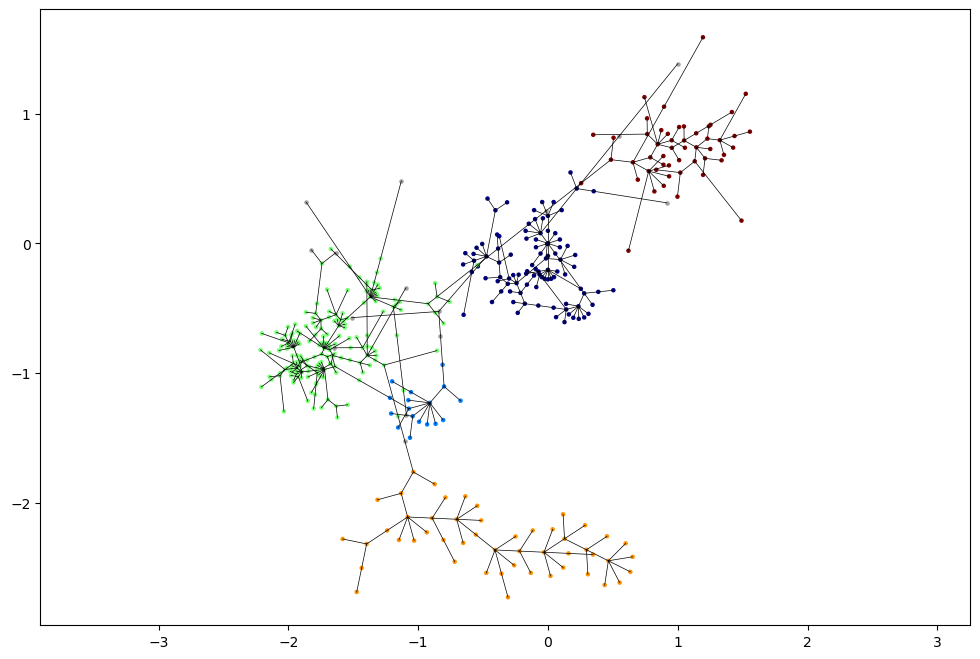

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = plot_tree(previous, dists, epss, ax)

mask = labels != -1
ax.scatter(pos[mask, 0], pos[mask, 1], s=5, c=labels[mask], cmap='jet')
ax.scatter(pos[mask == False, 0], pos[mask == False, 1], s=5, c='#A0A0A0')

ax.axis('equal')
plt.show()

## OPTICS Algorithm with Scikit-Learn

Scikit-Learn provides the [`OPTICS`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html) class. The only relevant parameter is `min_samples` (our $N$). There are two cluster identification routines available. One based on DBSCAN (with sensitivity parameter `eps`) and another one with sensitivity parameter `xi`. Note, that automatic cluster identification often yields poor results.

In [11]:
import sklearn.cluster as cluster

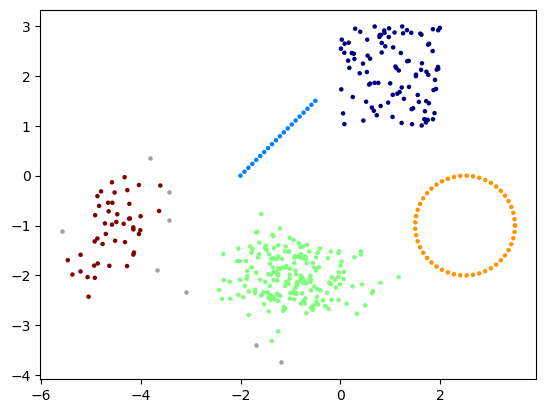

In [12]:
opt = cluster.OPTICS(min_samples=5, cluster_method='dbscan', eps=0.5)
opt.fit(X)

fig, ax = plt.subplots()
mask = opt.labels_ != -1
ax.scatter(X[mask, 0], X[mask, 1], s=5, c=opt.labels_[mask], cmap='jet')
ax.scatter(X[mask == False, 0], X[mask == False, 1], s=5, c='#A0A0A0')
ax.axis('equal')
plt.show()

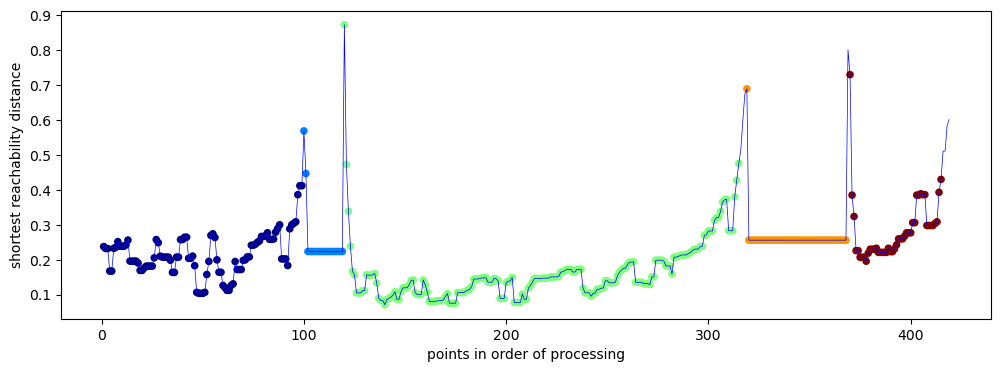

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(opt.reachability_[opt.ordering_] , '-b', linewidth=0.5)
ax.scatter(np.arange(0, n)[mask[opt.ordering_]], opt.reachability_[opt.ordering_][mask[opt.ordering_]], s=20, c=opt.labels_[opt.ordering_][mask[opt.ordering_]], cmap='jet')
ax.set_xlabel('points in order of processing')
ax.set_ylabel('shortest reachability distance')
plt.show()